## This Notebook outlines the image retrieval and the pre-processing for Demand Forecasting's Image Similarity Module
1. Read Image Metadata from PDNA Table
2. Use Image Storage Location List to retrieve images
3. Pre-process images to meet the requirements
4. Move images to a Sagemaker accessible S3 bucket using boto3

Note: Image retrieval and moving uses boto3 while all pre-processing is done using pyspark apply module

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
# findspark init() before importing pyspark
import findspark
findspark.init()

In [3]:
import pandas as pd
import numpy as np
import os
import sys

from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions as F

In [4]:
## Adding this location to path allows us to import the functions defined there directly
sys.path.insert(0, '../source')

In [5]:
from spark_utils import initialize
from spark_utils import table_display
spark_session = initialize(
    {
        "PYSPARK_PYTHON": "./rep-learn/bin/python",
        "PYSPARK_DRIVER_PYTHON": "~/miniconda3/envs/rep-learn",
        "spark.yarn.dist.archives": "../rep-learn.tar.gz#rep-learn",
        "spark.yarn.appMasterEnv.PYSPARK_PYTHON": "./rep-learn/bin/python"
    }
)

In [6]:
sc = spark_session.sparkContext
#sc._conf.getAll()

In [7]:
sqlContext = SQLContext(sc)
#histogram = sqlContext.read.csv("s3://das-usecases-eu-west-1-24fc/demand-forecasting/article_image_embeddings/20191009_color_histogram.csv", header = True)

#### Read image metadata and fetch summary statistics on number of images are present per group

In [8]:
image_md = spark_session.sql("SELECT * FROM preprod_lake.mvn_image_metadata where missing_reason_key == '' AND productview LIKE '%Side Lateral%'")

In [9]:
article_master = spark_session.sql("SELECT group_article, business_unit_descr FROM mart_out.md_group_article")

In [10]:
image_md = image_md.join(article_master, image_md["articlenumber"] == article_master["group_article"], "left_outer")

In [11]:
table_display(image_md)

In [12]:
import boto3
s3_client = boto3.client('s3')

In [13]:
s3_client.download_file("das-prod-inbound-mvn-eu-west-1-e706", "prod/images/AQ6030_35359942bad24c079584a802007d7a03.tif", "AQ6030_35359942bad24c079584a802007d7a03.tif")

In [14]:
table_display(image_md.crosstab('business_unit_descr', 'assetcategory'))

In [16]:
from pyspark.sql.functions import col
import pyspark.sql.functions as fn

In [16]:
table_display(image_md.groupby(['businessunit']).agg(fn.countDistinct('articlenumber')).alias('articlecount'))

In [17]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
from pyspark.sql.functions import array_contains

In [65]:
#from pyspark.sql.functions import split, explode
#image_md.select(explode(col('sellingseasons')).alias("sell_seasons"))

In [18]:
print(image_md.schema)

StructType(List(StructField(id,StringType,true),StructField(articlenumber,StringType,true),StructField(articlename,StringType,true),StructField(modelnumber,StringType,true),StructField(modelname,StringType,true),StructField(assetcategory,StringType,true),StructField(productview,StringType,true),StructField(imagestyle,StringType,true),StructField(brand,StringType,true),StructField(markets,StringType,true),StructField(businessunit,StringType,true),StructField(productdivisions,StringType,true),StructField(producttypes,StringType,true),StructField(agegroups,StringType,true),StructField(genders,StringType,true),StructField(sportscategories,StringType,true),StructField(sellingseasons,StringType,true),StructField(marketingseasons,StringType,true),StructField(assetname,StringType,true),StructField(workingnumber,StringType,true),StructField(createdon,StringType,true),StructField(modifiedon,StringType,true),StructField(metadataupdated,StringType,true),StructField(assetphases,StringType,true),Str

In [45]:
from itertools import groupby
from pyspark.sql import types as T
def function(x, value):
    result = 0
    for key in x:
        if key == value:
            result = 1
    return(result)

udfFunctionCall = F.udf(function, T.IntegerType())

In [ ]:
image_md = image_md.withColumn("FW16", udfFunctionCall(image_md['sellingseasons'], 'Fall/Winter 2016'))

In [18]:
table_display(image_md)

In [ ]:
df.select(df.name, df.new[0].alias("sport"), df.new[1].alias("position")).show(truncate=False)

In [9]:
so_by_season = sqlContext.read.csv("s3a://das-usecases-eu-west-1-24fc/demand-forecasting/article_image_embeddings/article_season_whs_so.csv", header = True)

In [10]:
article_master = spark_session.sql("SELECT group_article, business_unit_descr FROM mart_out.md_group_article")

In [11]:
so_by_season = so_by_season.join(article_master, so_by_season["Article_Number"] == article_master["group_article"], "inner")

In [17]:
table_display(so_by_season)

In [ ]:
table_display(so_by_season.crosstab('business_unit_descr', 'Season'))

### Fetch Train and Test Datasets

In [8]:
### csv containing the SO Quantities at an Article Number - Season grain
so_by_season = sqlContext.read.csv("s3a://das-usecases-eu-west-1-24fc/demand-forecasting/article_image_embeddings/article_season_whs_so.csv", header = True) \
                         .dropDuplicates(['Article_Number', 'Season'])

In [9]:
### Image storage metadata -- using just the article IDs for the time being -- to be explored later
image_md = spark_session.sql("SELECT id, articlenumber, articlename, modelname, assetcategory, productview, destination_path_key \
                                FROM preprod_lake.mvn_image_metadata where missing_reason_key == '' AND productview LIKE '%Side Lateral%'")

In [10]:
### extracting BU per article -- do I even need this is the question? Let's keep the BU and product group for now
article_master = spark_session.sql("SELECT group_article, business_unit_descr as BU, product_group_descr as Product_Group FROM mart_out.md_group_article") \
                              .dropDuplicates(['group_article'])

In [11]:
image_md = image_md.join(article_master, image_md["articlenumber"] == article_master["group_article"], "inner")
so_by_season = so_by_season.join(image_md, so_by_season['Article_Number'] == image_md['articlenumber'], 'inner') 

In [12]:
table_display(so_by_season.filter(so_by_season.productview == "Front Side Lateral Extra View"))

In [13]:
table_display(so_by_season.crosstab('assetcategory', 'productview'))

In [14]:
import boto3
import cv2
import matplotlib.pyplot as plt
def download_image(so_df, 
                   article_num,
                   season,
                   view,
                   category,
                   download_path = ".",
                   verbose = False,
                   show = True):
    s3_client = boto3.client('s3')
    
    s3_location = so_df.filter((so_df.productview == view) \
                               & (so_df.assetcategory == category) \
                               & (so_df.Article_Number == article_num) \
                               & (so_df.Season == season)) \
                       .select('destination_path_key') \
                       .collect()
    
    s3_location = s3_location[0].destination_path_key
    
    split_path = s3_location.split('/')
    s3_bucket = split_path[0]
    obj_name = split_path[-1]
    
    split_path.pop(0)
    s3_path = ("/").join(split_path)

    
    s3_client.download_file(s3_bucket, s3_path, obj_name)
    if verbose:
        print("Downloaded image from {} to {}".format(s3_bucket + "/" + s3_path \
              , download_path + '/' + obj_name))
    if show:
        img_path = download_path + '/' + obj_name
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        plt.imshow(img)

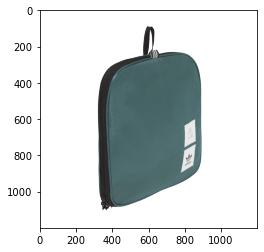

In [15]:
download_image(so_by_season, "DV0262", "SS 2019", "Front Side Lateral Extra View", "Photography")

In [16]:
views = so_by_season.select('productview').distinct().toPandas()['productview'].tolist()

/home/kovuruda/miniconda3/envs/py_env/lib/python3.7/site-packages/pyarrow/__init__.py:157: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "


In [17]:
categories = so_by_season.select('assetcategory').distinct().toPandas()['assetcategory'].tolist()

In [20]:
table_display(so_by_season.crosstab('productview', 'assetcategory'))

In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
from preprocess import *

numpy.ndarray

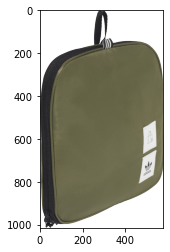

In [22]:
type(pre_process("./DV0262_2ff8bb6808c64dd7a266aa5300e013a8.tif"))

In [65]:
def get_train_test_seasons(so_df,val_season = "SS 2020"):
    def seas_key(x):
        seas, year = x.split()
        return -int(year), seas != "SS"
    
    sorted_seasons = so_df.select('Season') \
                   .distinct() \
                   .rdd.map(lambda r:r[0]) \
                   .collect()
    
    sorted_seasons.sort(key = seas_key, reverse=True)
    
    return(sorted_seasons)

In [21]:
### create index file indicating the folder structure based on grouping specified
def index_from_data(so_df, categories = None, views = None, validation_season = "SS 2019"):
    import pyspark.sql.functions as f
    from operator import add
    from functools import reduce
    from pyspark.sql.functions import col, create_map, lit
    from itertools import chain
    from pyspark.sql import Window
    
    def seas_key(x):
        seas, year = x.split()
        return -int(year), seas != "SS"
    
    sorted_seasons = so_df.select('Season') \
                          .distinct() \
                          .rdd.map(lambda r:r[0]) \
                          .collect()
    
    sorted_seasons.sort(key = seas_key, reverse=True)

    sorted_seasons = dict(zip(sorted_seasons, range(len(sorted_seasons))))
    print(sorted_seasons)
    
    if categories is None:
        categories = ['3D - Rendering', "3D - Rendering Retouched",\
                      "Photography", "Photography - eCommerce"]
    if views is None:
        views = ["Side Lateral View", "Side Lateral Left View", "Side Lateral Center View",\
                 "Left Side Lateral View", "Side Lateral Center Open View"\
                 "Front Side Lateral View", "Front Side Lateral Extra View"]
    
    views = dict(zip(views, range(len(views))))
    categories = dict(zip(categories, range(len(categories))))
    
    ## generate mappers and apply to columns
    season_map = create_map([lit(x) for x in chain(*sorted_seasons.items())])
    
    view_map = create_map([lit(x) for x in chain(*views.items())])
    
    category_map = create_map([lit(x) for x in chain(*categories.items())])
    
    ### get priority image i.e. dataset converted to one row per article
    w = Window.partitionBy([col(x) for x in ['Article_Number']])

    so_df = so_df.withColumn("season_num", season_map.getItem(so_df.Season))\
                  .withColumn("view_score", view_map.getItem(so_df.productview))\
                  .withColumn("category_score", category_map.getItem(so_df.assetcategory))\
                  .withColumn('cumulative_score',\
                              reduce(add,[F.col(x) for x in ['view_score', 'category_score']]))\
                  .withColumn('min_score',\
                              f.min('cumulative_score').over(w))\
                  .where(f.col('cumulative_score') == f.col('min_score'))\
                  .drop('min_score')\
                  .withColumn('view_min', f.min('view_score').over(w))\
                  .where(f.col('view_score') == f.col('view_min'))\
                  .drop('view_min')\
                  .withColumn('max_season', f.max('season_num').over(w))\
                  .where(f.col('season_num') == f.col('max_season'))\
                  .drop('max_season')\
                  .dropDuplicates(["Article_Number"])

    valid_num = sorted_seasons[validation_season]
    ### clean nulls
    so_df = so_df.filter((so_df.view_score.isNotNull()) &\
                         (so_df.category_score.isNotNull()))\
                 .filter((so_df.destination_path_key.isNotNull()))
                 #.filter((so_df.BU.isNotNull()))
    
    ## demarcate and separate train-test parts of the index
    so_df = so_df.filter(F.col('season_num') <= valid_num)\
                 .withColumn('assignment',F.when(F.col("season_num") == valid_num, 'Test')\
                             .otherwise('Train'))
    
    return(so_df)

In [22]:
so_by_season = index_from_data(so_by_season)

{'FW 2016': 0, 'FW 2017': 1, 'SS 2017': 2, 'FW 2018': 3, 'SS 2018': 4, 'FW 2019': 5, 'SS 2019': 6, 'SS 2020': 7}


In [23]:
table_display(so_by_season.crosstab('assignment', 'Season'))

In [24]:
## doing this in Pandas to simplify things -- to be ported to pyspark
## this should be seen as a failure to do everything with pyspark -- schade schade
so_by_season = so_by_season.toPandas()

def generate_labels(so_df, grouping = "Product_Group", value = 'SO_Quantity', validation_season = 'SS 2019', label = 'label'):
    
    def quantile_bins(value):
        bins = 5 
        labels = None
        if labels is None:
            labels = ["Bin_" + str(val) for val in list(range(bins))]
        bin_labels = pd.qcut(pd.to_numeric(value), bins, labels=labels)
        return(bin_labels)
    
    so_df[label] = so_df.groupby(grouping, group_keys=False)[value].transform(quantile_bins)
    
    
    return(so_df)

/home/kovuruda/miniconda3/envs/py_env/lib/python3.7/site-packages/pyarrow/__init__.py:157: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "


In [25]:
train_test_index = generate_labels(so_by_season)

In [31]:
train_test_index.head()

,Article_Number,Season,SO_Quantity,id,articlenumber,articlename,modelname,assetcategory,productview,destination_path_key,group_article,BU,Product_Group,season_num,view_score,category_score,cumulative_score,assignment,label
0,AF4543,FW 2016,12448,8de207e56a5644d39406a45a0175a337,AF4543,lk sport 2 k,lk sport 2 k,3D - Rendering,Side Lateral View,das-prod-inbound-mvn-eu-west-1-e706/prod/images/AF4543_8de207e56a5644d39406a45a0175a337.tif,AF4543,BU YOUNG ATHLETES,SHOES,0,0,0,0,Train,Bin_4
1,AH2545,FW 2018,860,75fae37661ce433795faa7990065f623,AH2545,RapidaFlex EL K,RapidaFlex EL K,3D - Rendering,Side Lateral View,das-prod-inbound-mvn-eu-west-1-e706/prod/images/AH2545_75fae37661ce433795faa7990065f623.tif,AH2545,BU YOUNG ATHLETES,SHOES,3,0,0,0,Train,Bin_1
2,AQ1109,FW 2018,1461,dcba6719393f46809e7aa7af000e669f,AQ1109,F/2 TR PK,F/2 TR PK,3D - Rendering,Side Lateral View,das-prod-inbound-mvn-eu-west-1-e706/prod/images/AQ1109_dcba6719393f46809e7aa7af000e669f.tif,AQ1109,BU ORIGINALS FTW,SHOES,3,0,0,0,Train,Bin_1
3,AQ1675,FW 2017,9473,78ec42cc9ff04453b93ca78200f72ead,AQ1675,CF RACER TR K,CF RACER TR K,Photography,Side Lateral View,das-prod-inbound-mvn-eu-west-1-e706/prod/images/AQ1675_78ec42cc9ff04453b93ca78200f72ead.tif,AQ1675,BU CORE FTW,SHOES,1,0,2,2,Train,Bin_4
4,AQ3019,FW 2016,1234,155375c42adf45d5ab69a48400a4fcd8,AQ3019,Volley Team 4,Volley Team 4,3D - Rendering,Side Lateral View,das-prod-inbound-mvn-eu-west-1-e706/prod/images/AQ3019_155375c42adf45d5ab69a48400a4fcd8.tif,AQ3019,BU SPECIALIST SPORT,SHOES,0,0,0,0,Train,Bin_1


In [27]:
run_tag = "ss_2019"
train_test_index.to_csv("../index/train_test_index_{}.csv".format(run_tag), index=False, index_label=False)

In [3]:
import os
import boto3
import time

In [ ]:
SOURCE_DIR='../source/similarity'
WORKING_DIR = os.getcwd()

SAGEMAKER_BUCKET =  "sagemaker-eu-west-1-534248273601" #sagemaker_session.default_bucket()
sagemaker_session._default_bucket = SAGEMAKER_BUCKET

SAGEMAKER_BUCKET_PREFIX = '/kovuruda/sagemaker/shop-by-style/data'

role = sagemaker.get_execution_role()
DATA_S3URI = "s3://"+SAGEMAKER_BUCKET+SAGEMAKER_BUCKET_PREFIX
AWS_REGION = boto3.session.Session().region_name

print("Your region: "+AWS_REGION)
print("Your SageMaker bucket: "+SAGEMAKER_BUCKET)
print("Your current working directory: "+WORKING_DIR)
print("Your training data location: " + DATA_S3URI)

In [ ]:
MODELS_S3URI = "s3://"+os.path.join(SAGEMAKER_BUCKET,'kovuruda','sagemaker','shop-by-style','model','output')
SOURCE_S3URI = "s3://"+os.path.join(SAGEMAKER_BUCKET,'kovuruda','sagemaker','shop-by-style','model','source')
OUTPUT_DIR = "s3://" + SAGEMAKER_BUCKET + SAGEMAKER_BUCKET_PREFIX + "/output"
print(OUTPUT_DIR)
MODEL_VERSION = 6

In [ ]:
DATA_S3URI = "s3://sagemaker-eu-west-1-534248273601/kovuruda/sagemaker/DEMO-pytorch-siamese-network/batch/in/"

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable
from torchvision import models

In [ ]:
model = models.resnet50(pretrained = True)

torch.save(model, "resnet50.pth")

os.system('aws s3 cp model.pth --quiet'
          .format(MODELS_S3URI))

In [ ]:
resnet152 = models.resnet152(pretrained=True)
modules=list(resnet152.children())[:-1]
resnet152=nn.Sequential(*modules)
for p in resnet152.parameters():
    p.requires_grad = False

In [ ]:
img = torch.Tensor(3, 224, 224).normal_() # random image
img_var = Variable(img) # assign it to a variable
features_var = resnet152(img_var) # get the output from the last hidden layer of the pretrained resnet
features = features_var.data # get the tensor out of the variable